In [108]:
#import libraries
import pandas as pd
import seaborn as sns
import math
import collections
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import nilearn.plotting as plotting

# Load data

In [29]:
#path to matrices
path = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/PTN_data/netmats2_15.txt' #netmats 2 = partial correlation, 15 = 15 nodes

#path to subject IDs of PTN data
path_sub = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/PTN_data/subjectIDs_recon2.txt'

#path to behavioral data (analyzed in the analyze_behavior notebook)
path_behavior = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/HCP_behavior_includeZscores.csv'

netmats = np.loadtxt(path)
subject_IDs = np.loadtxt(path_sub)
df = pd.read_csv(path_behavior)

In [30]:
#number of subjects in the PTN data
netmats.shape
len(subject_IDs)

#number of subjects in the behavior data
df.shape

(812, 225)

812

(844, 573)

# Pre-processing 

## Exclusion of subjects according to the behavioral data

In [31]:
#Exclude subjects in the behavior data so it would be the same as the PTN data
df = df[df['Subject'].isin(subject_IDs)]

df.shape

(655, 573)

In [32]:
#Find the subjects that are excluded in the behavior data
print("Number of subjects in the PTN data is {0}".format(len(subject_IDs)))

subjectBehavior = df['Subject']
print("And, the number of subjects in the behavior data is {0}".format(len(subjectBehavior)))

#difference between behavior and fMRI data sets
subjectDifference = np.setdiff1d(subject_IDs, subjectBehavior)
print("So, the difference between the two data sets is {0}".format(len(subjectDifference)))

Number of subjects in the PTN data is 812
And, the number of subjects in the behavior data is 655
So, the difference between the two data sets is 157


In [33]:
#Exclude the subjects that are not in the behavior data from the fMRI data
id_to_array = dict(zip(subject_IDs,range(len(subject_IDs))))

netmats = np.delete(netmats,[id_to_array[sub] for sub in subjectDifference], axis=0)

netmats.shape

(655, 225)

## Pre-processing of the matrices

In [66]:
num_nodes = math.sqrt(netmats.shape[1])

print("There are {0} subjects, and {1} nodes".format(netmats.shape[0], num_nodes))

There are 655 subjects, and 15.0 nodes


(15, 15)

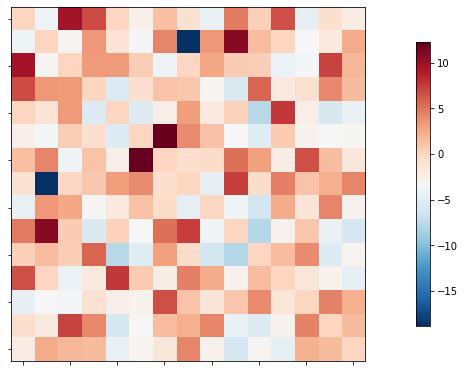

In [78]:
#Example of a matrix of one subject
num_nodes = int(num_nodes)
arr_2d = np.reshape(netmats[0], (num_nodes, num_nodes))
arr_2d.shape

plotting.plot_matrix(arr_2d)

In [74]:
# take just the upper triangle
X_features = {}

## convert num_nodes from float to int
num_nodes = int(math.sqrt(netmats.shape[1]))

for i in range(len(subjectBehavior)):
    tmp = np.reshape(netmats[i], (num_nodes, num_nodes)) #convert netmats from 1d array to 2d array for each subject
    X_features[i] = tmp[np.triu_indices_from(tmp, k=1)]
    
# Convert dictionary into dataframe
X_features = pd.DataFrame.from_dict(X_features, orient='index')

X_features.shape    

(655, 105)

Text(0.5, 1.0, 'feature matrix')

Text(0.5, 0, 'features')

Text(0, 0.5, 'subjects')

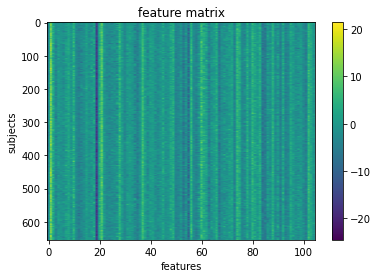

In [75]:
plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

# Model

In [79]:
from sklearn.model_selection import train_test_split

# Split the sample to training/validation with a 60/40 ratio, and 
# stratify by neuroticsm score, and also shuffle the data.

score_y = df['z_score_compare_f']

X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    score_y, # y
                                                    test_size = 0.4, # 60%/40% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    #stratify = score_n,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

training: 393 testing: 262


<AxesSubplot:xlabel='z_score_compare_f'>

<AxesSubplot:xlabel='z_score_compare_f'>

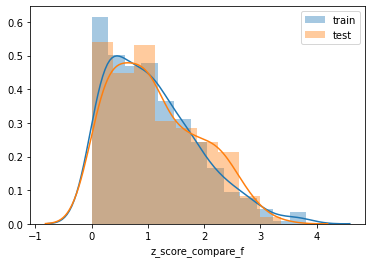

In [80]:
#Examine the distributions of y_train and y_test
sns.distplot(y_train,label='train')
sns.distplot(y_val,label='test')
plt.legend()

## SVR model

In [81]:
#Cross-validation
#X_train = principalComponents

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

l_svr = SVR(kernel='linear') # define the model

# predict
y_pred = cross_val_predict(l_svr, X_train, y_train, cv=10)
# scores
acc = cross_val_score(l_svr, X_train, y_train, cv=10)
mae = cross_val_score(l_svr, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

In [82]:
for i in range(10):
    print('Fold {} -- Acc = {}, MAE = {}'.format(i, acc[i],-mae[i]))

Fold 0 -- Acc = -0.6136637856466376, MAE = 0.6730264276400586
Fold 1 -- Acc = -0.40700631393783127, MAE = 0.7060666192699295
Fold 2 -- Acc = -0.7162743353452581, MAE = 0.9553681196754316
Fold 3 -- Acc = -0.652393589729829, MAE = 0.8067141564656303
Fold 4 -- Acc = -0.36666921149724696, MAE = 0.7560651074814035
Fold 5 -- Acc = -0.3553225485133129, MAE = 0.711639936368404
Fold 6 -- Acc = -0.9456797443515574, MAE = 0.7596952606614688
Fold 7 -- Acc = -0.6949907080134339, MAE = 0.8121305136221094
Fold 8 -- Acc = -0.3825201206414097, MAE = 0.7791815010759764
Fold 9 -- Acc = -0.4959151678527871, MAE = 0.8983733862818244


R2: -0.514429248118047
MAE: 0.7857675350629328


<AxesSubplot:ylabel='z_score_compare_f'>

Text(0.5, 0, 'Predicted Y')

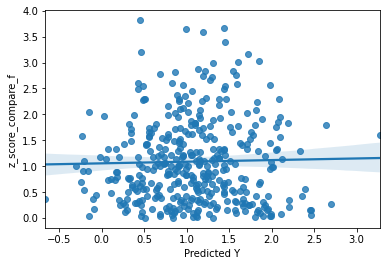

In [83]:
from sklearn.metrics import r2_score

overall_acc = r2_score(y_train, y_pred)
overall_mae = mean_absolute_error(y_train,y_pred)
print('R2:',overall_acc)
print('MAE:',overall_mae)

sns.regplot(y_pred, y_train)
plt.xlabel('Predicted Y')

## Ridge regression

In [96]:
#Cross-validation
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn import linear_model

model = linear_model.Ridge(alpha=1.0) #define model

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1) # define model evaluation method

scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.764 (0.090)


In [101]:
model.fit(X_train, y_train)
yhat = model.predict(X_val)

Ridge()

R2: -0.4422795518325091
MAE: 0.7583794077628665


<AxesSubplot:xlabel='z_score_compare_f'>

Text(0.5, 0, 'z_compare_f')

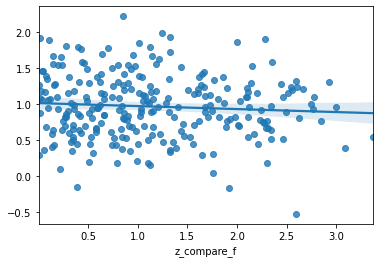

In [102]:
from sklearn.metrics import r2_score

overall_acc = r2_score(y_val, yhat)
overall_mae = mean_absolute_error(y_val, yhat)
print('R2:',overall_acc)
print('MAE:',overall_mae)

sns.regplot(y_val, yhat)
plt.xlabel('z_compare_f')

## Clustering x_features: K-Means

In [103]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

kmeans = KMeans(n_clusters=4, max_iter=600, algorithm = 'auto')
kmeans.fit(X_features)

KMeans(max_iter=600, n_clusters=4)

In [104]:
kmeans.labels_

array([3, 2, 3, 3, 1, 2, 2, 2, 1, 3, 0, 3, 2, 1, 1, 2, 1, 3, 1, 3, 3, 2,
       1, 0, 0, 1, 0, 1, 2, 2, 3, 2, 2, 3, 3, 3, 1, 2, 3, 1, 3, 2, 3, 2,
       1, 1, 0, 2, 1, 2, 3, 1, 1, 0, 1, 3, 3, 2, 0, 3, 0, 0, 3, 2, 2, 1,
       3, 3, 1, 2, 0, 1, 3, 3, 0, 1, 3, 2, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1,
       3, 0, 3, 3, 1, 3, 2, 2, 3, 2, 1, 2, 0, 3, 0, 2, 1, 1, 2, 2, 1, 0,
       0, 0, 1, 0, 3, 1, 1, 1, 1, 1, 3, 0, 3, 1, 2, 1, 1, 1, 2, 1, 2, 3,
       2, 1, 3, 1, 1, 3, 0, 1, 1, 3, 3, 1, 0, 1, 1, 0, 0, 1, 2, 2, 1, 2,
       1, 2, 0, 1, 3, 0, 0, 2, 2, 1, 1, 2, 2, 2, 0, 1, 2, 1, 3, 3, 1, 2,
       0, 2, 1, 3, 2, 3, 0, 3, 2, 2, 1, 2, 0, 2, 2, 2, 1, 1, 2, 3, 2, 0,
       2, 2, 3, 3, 3, 2, 0, 1, 1, 1, 0, 2, 1, 0, 0, 2, 2, 2, 3, 2, 1, 2,
       3, 2, 1, 1, 1, 3, 3, 0, 2, 1, 1, 1, 3, 1, 0, 3, 3, 1, 1, 1, 1, 0,
       3, 1, 3, 1, 0, 1, 0, 1, 1, 3, 2, 0, 2, 1, 0, 1, 1, 2, 1, 2, 1, 2,
       3, 1, 3, 1, 1, 2, 2, 1, 2, 3, 2, 1, 3, 0, 3, 3, 0, 1, 2, 2, 1, 0,
       1, 0, 2, 3, 2, 2, 3, 3, 2, 1, 0, 0, 2, 3, 1,

In [106]:
df['K_means_group'] = kmeans.labels_
df.head()

,Unnamed: 0,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,...,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,z_score_mars,z_score_DDisc_AUC,z_score_Flanker,GroupType_f,z_score_compare_f,K_means_group
0,1,100206,S900,Q11,M,26-30,True,1,1,4,...,72.03,1.84,0.0,1.84,0.053852,-1.649623,1.435010,3,3.084632,3
3,8,101309,S500,Q06,M,26-30,True,1,1,4,...,104.39,1.80,0.0,1.80,-0.033364,1.547886,0.115483,2,1.432402,2
5,11,101915,Q3,Q04,F,31-35,True,2,2,4,...,111.70,1.84,1.0,1.80,-0.033364,1.454413,-1.313170,1,2.767582,3
6,12,102008,S500,Q06,M,22-25,False,1,1,4,...,65.31,1.80,0.0,1.80,-0.033364,-0.881943,0.327729,3,1.209672,3
7,15,102513,S900,Q10,M,26-30,True,2,2,4,...,82.37,1.92,0.0,1.92,0.228284,-1.324782,-2.944056,0,1.619274,1


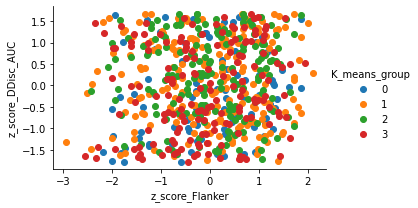

In [110]:
fg = sns.FacetGrid(data=df, hue='K_means_group', aspect=1.61)
fg.map(plt.scatter, 'z_score_Flanker', 'z_score_DDisc_AUC').add_legend()

In [ ]:
fg = seaborn.FacetGrid(data=df, hue='GroupType_f', aspect=1.61)
fg.map(pyplot.scatter, 'z_score_Flanker', 'z_score_DDisc_AUC').add_legend()